# Gastrointestinal diesease detection using Kvasir dataset

We would like to use the Kvasir in order to classify endoscopic images. 

The Kvasir dataset contains 8000 images total. 
1000 endoscopic images from 8 different categories: 

- Dyed lifted polyps
- Dyed resection margins
- Esophagitis
- Normal cecum
- Normal pylorus
- Normal z line
- Polyps
- Ulcerative colitis

The data has been verified by experienced endoscopists.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#using fastai libraries
from fastai import *
from fastai.vision import *
from fastai.metrics import error_rate

In [3]:
path = Path('/Users/Othmane/Documents/computer-vision/kvasir-dataset-v2'); path.ls()

[PosixPath('/Users/Othmane/Documents/computer-vision/kvasir-dataset-v2/valid'),
 PosixPath('/Users/Othmane/Documents/computer-vision/kvasir-dataset-v2/.DS_Store'),
 PosixPath('/Users/Othmane/Documents/computer-vision/kvasir-dataset-v2/test'),
 PosixPath('/Users/Othmane/Documents/computer-vision/kvasir-dataset-v2/models'),
 PosixPath('/Users/Othmane/Documents/computer-vision/kvasir-dataset-v2/train')]

Get and format the data using ImageDataBunch that takes in the following parameters:
- path : folder that contains the data stored in train/test/validate folders
- ds_tfms : the transformations we want to perform on the images
- size : how big the images should be
- bs : batchsize that we can fit with the GPU Ram

In [5]:
# We are using batchsize of 64
batch_size = 64
# , ds_tfms=tfms
data = ImageDataBunch.from_folder(path, size=224, bs=batch_size)

In [6]:
# lists out the classes
print(data.classes)

['dyed-lifted-polyps', 'dyed-resection-margins', 'esophagitis', 'normal-cecum', 'normal-pylorus', 'normal-z-line', 'polyps', 'ulcerative-colitis']


# How is our data looking like ?

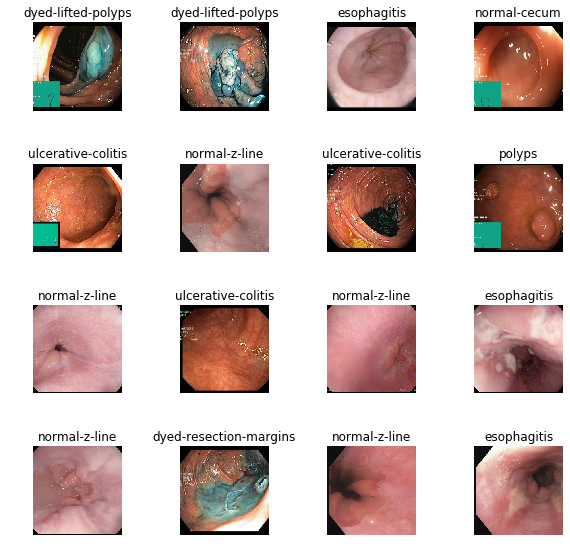

In [7]:
#show some of them with labels
data.show_batch(rows=4, figsize=(8,8))

# Training

We will be training a CNN (convolutional neural network) based of the [resnet](https://towardsdatascience.com/understanding-and-visualizing-resnets-442284831be8?gi=afe588900ed9). To start of we will be using 34 layers. To create a CNN with fast.ai we would need: 
- data : the data object we created earlier
- architecture : the CNN architecture we will be using (in our case a 34 layer Resnet)
- metrics : the metrics to judge the performance of our neural network

In [8]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [9]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.794649,0.444167,0.168750,12:18
1,0.457248,0.426840,0.155000,11:31
2,0.311656,0.396068,0.147500,10:02
3,0.235549,0.385618,0.145000,10:02


In [10]:
learn.save('Kvest-1')

# Results

In [11]:
# This gathers the data together for the comparing top losses and confusion Matrix
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

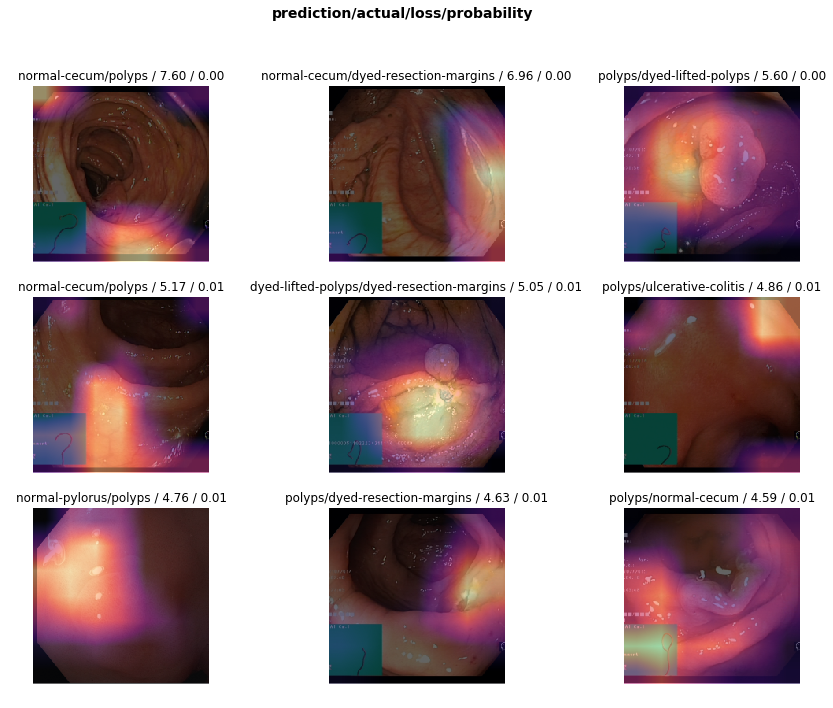

In [12]:
#Lists the top categories
interp.plot_top_losses(9, figsize=(15,11))

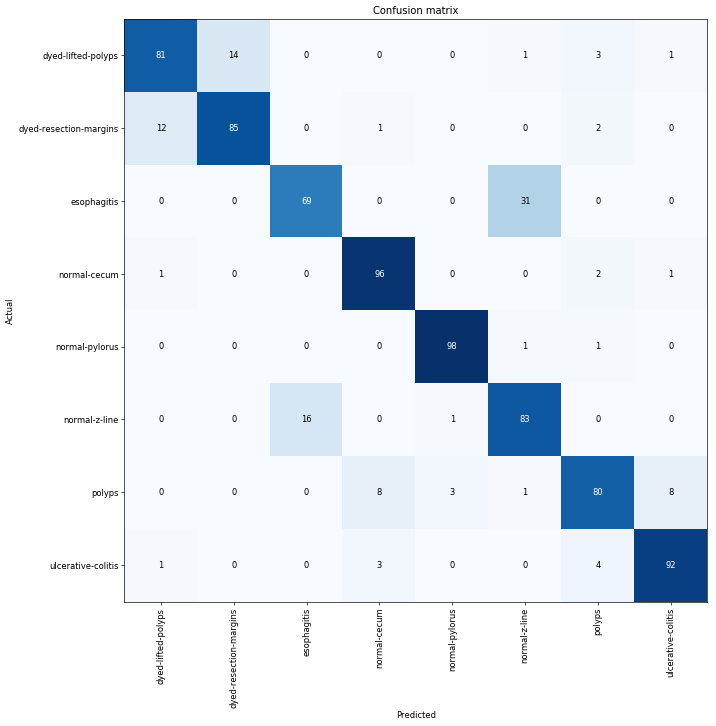

In [13]:
#shows where things went wrong in a confusion matrix
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

From this confusion matrix we can notice that the number one misclassification is between esophagitis and normal-z-line images.

## Fine-tuning weights and learning rates

In [14]:
# We are going to fine tune the model.
# First we want to load the previous weights
learn.load('Kvest-1');
# We are going to find the optimal learning rate curve
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


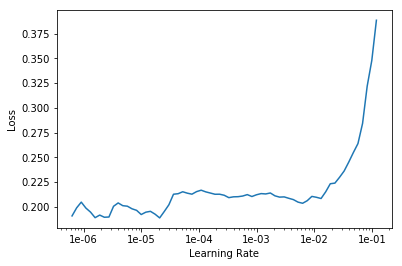

In [15]:
#shows the curve; we choose a point that is at its lowest
learn.recorder.plot()

In [16]:
#we are going to unfreeze the model allowing the pretrained weights to move around a bit.
learn.unfreeze()
#we break this up. Lower layers change weights more slowly than higher layers. Run twice
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.200002,0.372763,0.140000,13:14
1,0.157244,0.376743,0.136250,13:15


In [17]:
#we break this up. Lower layers change weights more slowly than higher layers. Run twice
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.129318,0.376479,0.143750,13:14
1,0.107650,0.375098,0.128750,13:14


In [18]:
# Save our new findings
learn.save('Kvest-2')

## Unfreezing and fine-tuning results

In [19]:
# This gathers the data together for the comparing top losses and confusion Matrix
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

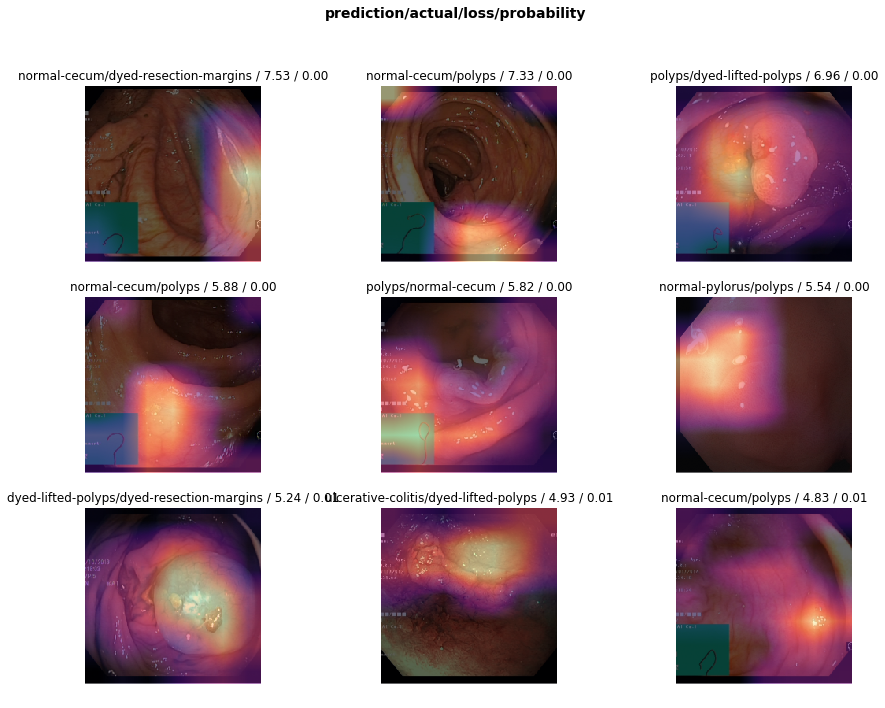

In [20]:
#Lists the top categories
interp.plot_top_losses(9, figsize=(15,11))

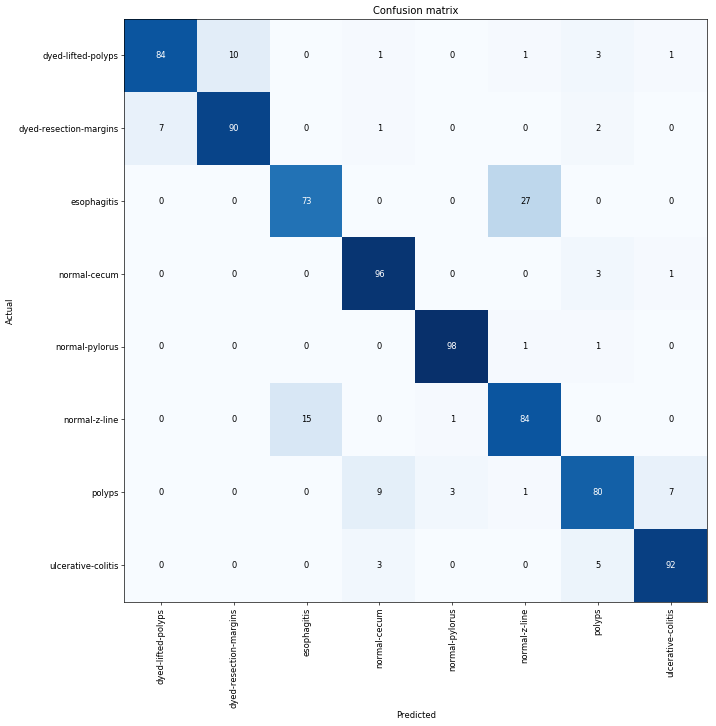

In [21]:
#shows where things went wrong in a confusion matrix
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [22]:
#most confused
interp.most_confused(min_val=2)

[('esophagitis', 'normal-z-line', 27),
 ('normal-z-line', 'esophagitis', 15),
 ('dyed-lifted-polyps', 'dyed-resection-margins', 10),
 ('polyps', 'normal-cecum', 9),
 ('dyed-resection-margins', 'dyed-lifted-polyps', 7),
 ('polyps', 'ulcerative-colitis', 7),
 ('ulcerative-colitis', 'polyps', 5),
 ('dyed-lifted-polyps', 'polyps', 3),
 ('normal-cecum', 'polyps', 3),
 ('polyps', 'normal-pylorus', 3),
 ('ulcerative-colitis', 'normal-cecum', 3),
 ('dyed-resection-margins', 'polyps', 2)]

It does look like that the fine tuning of the results helped a little bit. Let's see if we can improve our model even more.

# Model improvement with data augmentation
Let's see if we can improve our resnet34 CNN with more data. 
Data augmentation is a common way to increase the size of the dataset used. Since we are dealing with endoscopic images (which are basicaly photos taken with a camera inside the gastrointestinal tract) we can use and abuse of data augmentation. In fact, images can be rotated horizontally, vertically or zoomed in at different levels. We could even play around with lighting. 

In [23]:
# decrease the batch size even further
bs= 24

In [24]:
data= ImageDataBunch.from_folder(path, ds_tfms=get_transforms(do_flip=True, flip_vert=True, max_lighting=0.2, max_rotate=359, 
                                                              max_zoom=1.05, max_warp=0.2), size=500, bs=bs//4).normalize(imagenet_stats)

Creating a new learner with: 
- data : information provided
- model : the architecture we are using resnet34 (same as before)
- metrics : what we use to gauge success

In [26]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


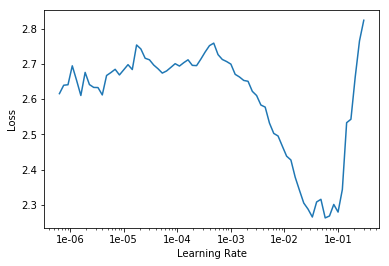

In [27]:
learn.lr_find()
learn.recorder.plot()

In [28]:
learn.fit_one_cycle(6)

epoch,train_loss,valid_loss,error_rate,time
0,0.911857,0.601064,0.217500,51:09
1,0.765985,0.536376,0.216250,47:01
2,0.688333,0.494601,0.198750,47:07
3,0.538186,0.386523,0.158750,47:09
4,0.484728,0.346808,0.133750,47:07
5,0.465654,0.334900,0.132500,47:05


In [29]:
learn.save('kveset-1-50')

In [30]:
learn.unfreeze()
learn.fit_one_cycle(6, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.477709,0.309500,0.126250,1:03:32
1,0.467784,0.298762,0.127500,1:03:26
2,0.410292,0.275940,0.110000,1:03:28
3,0.467391,0.267338,0.108750,1:03:21
4,0.405961,0.253246,0.108750,1:06:34
5,0.289406,0.255398,0.100000,1:04:39
6,0.339286,0.253154,0.110000,1:04:18
7,0.369779,0.240496,0.097500,1:04:22


In [31]:
learn.save('kveset-1-50')

In [32]:
learn.load('kveset-1-50');

In [33]:
interp = ClassificationInterpretation.from_learner(learn)

In [34]:
interp.most_confused(min_val=2)

[('esophagitis', 'normal-z-line', 27),
 ('normal-z-line', 'esophagitis', 13),
 ('dyed-resection-margins', 'dyed-lifted-polyps', 6),
 ('polyps', 'normal-cecum', 6),
 ('ulcerative-colitis', 'normal-cecum', 5),
 ('polyps', 'ulcerative-colitis', 4),
 ('dyed-lifted-polyps', 'polyps', 3),
 ('ulcerative-colitis', 'polyps', 3),
 ('dyed-lifted-polyps', 'dyed-resection-margins', 2),
 ('normal-cecum', 'polyps', 2),
 ('polyps', 'normal-pylorus', 2)]

## Results

In [35]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

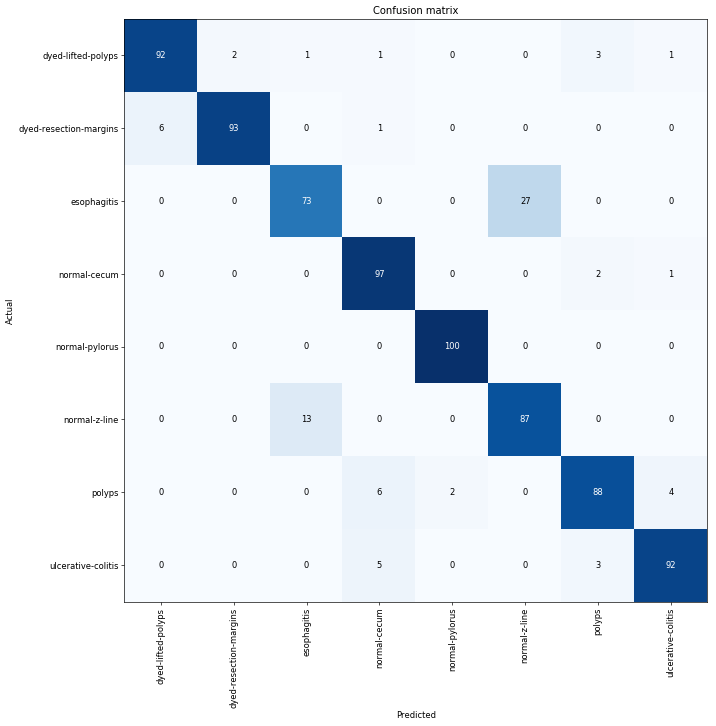

In [36]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

Data augmentation did help a lot. In fact it reduced mislclassification from the lower left part of the confusion matrix (normal-z-line/esophagitis, polyps/normal-cecum, polyps/normal-polypus). However, the number one misclassification (esophagitis/normal-z-line) still remains unchanged.

# Last but not least

90% success rate is fairly good for a classifier that has been run on a laptop only using the 34 layer resnet. For sure the data augmentation helped since it was very easy to augment endoscopic images (all images can be fliped in any angle that we want). 
However, confusion remains on some known cases which is probably an indicator that multiple classfiers are needed to better solve this problem. 

Next steps could be to try out a resnet with more layers then multiple classifiers.

To be continued... :)